# Siamese Network

- Example from keras: https://keras.io/examples/mnist_siamese/
- Create a siamese neural network to reconnise hand written digits

In [1]:
from __future__ import absolute_import
from __future__ import print_function
import numpy as np

import random
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda
from keras.optimizers import RMSprop
from keras import backend as K

Using TensorFlow backend.


In [2]:
num_classes = 10
epochs = 20

## Data preprocessing

In [3]:
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

In [4]:
import matplotlib.pyplot as plt
def viewMinst(mtr, mtr2):
    """view minst"""
    mtr = mtr.reshape(28,28)
    mtr2 = mtr2.reshape(28,28)
    plt.imshow( np.concatenate((mtr,mtr2), axis=1 ) , cmap='gray')
    plt.show()

In [5]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
input_shape = x_train.shape[1:]

In [6]:
# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices)

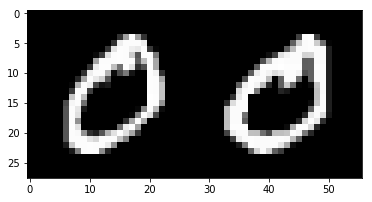

In [7]:
viewMinst(tr_pairs[0][0],tr_pairs[0][1])

Case where $y = 1$

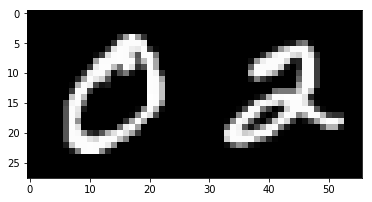

In [8]:
viewMinst(tr_pairs[1][0],tr_pairs[1][1])

Case where $y = 0$

## Siamese network Model

### Evaluation metric

In [9]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

$$euclidean\_distance:   x, y \longrightarrow  \sum_{i \in I}  (x_{i} - y_{i} )^2  $$

In [10]:
def eucl_dist_output_shape(shapes):
    """Return the shape the first element of shape contener in a tuple (shape,1)
    """
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [11]:
def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

- Ratio of correct prediction

In [12]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

In [13]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    sqaure_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * sqaure_pred + (1 - y_true) * margin_square)

### Model creation

In [14]:
def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input = Input(shape=input_shape)
    x = Flatten()(input)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    return Model(input, x)

In [15]:
# network definition
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)


In [16]:
# train
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=128,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

Train on 108400 samples, validate on 17820 samples
Epoch 1/20
108400/108400 [==============================] - 6s 57us/step - loss: 0.0988 - accuracy: 0.8818 - val_loss: 0.0440 - val_accuracy: 0.9555
Epoch 2/20
108400/108400 [==============================] - 4s 35us/step - loss: 0.0407 - accuracy: 0.9595 - val_loss: 0.0302 - val_accuracy: 0.9700
Epoch 3/20
108400/108400 [==============================] - 4s 35us/step - loss: 0.0277 - accuracy: 0.9724 - val_loss: 0.0261 - val_accuracy: 0.9727
Epoch 4/20
108400/108400 [==============================] - 4s 36us/step - loss: 0.0222 - accuracy: 0.9773 - val_loss: 0.0246 - val_accuracy: 0.9735
Epoch 5/20
108400/108400 [==============================] - 4s 35us/step - loss: 0.0187 - accuracy: 0.9811 - val_loss: 0.0242 - val_accuracy: 0.9726
Epoch 6/20
108400/108400 [==============================] - 4s 35us/step - loss: 0.0165 - accuracy: 0.9830 - val_loss: 0.0239 - val_accuracy: 0.9721
Epoch 7/20
108400/108400 [=============================

In [17]:
# compute final accuracy on training and test sets
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

* Accuracy on training set: 99.67%
* Accuracy on test set: 97.30%
